In [1]:
!nvidia-smi

Thu Jul 16 10:35:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train class samples from DP data
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/"DP Data"/1/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/"DP Data"/1/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [5]:
# Copying DP training Data with epsilon 1 to local to process/train faster

!cp -R /content/drive/"My Drive"/"DP Data"/1/train ./

In [6]:
# Validation samples from Non DP data
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [7]:
# Copying to Non DP Validation data to local to process/run faster during validation inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

In [8]:
# Testing samples from Non DP data
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [9]:
# Copying to Non DP Validation data to local to process/run faster during testing inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [10]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 10 16:29 sample_data
drwx------ 4 root root 4096 Jul 16 10:35 drive
dr-x------ 4 root root 4096 Jul 16 11:16 train
drwx------ 4 root root 4096 Jul 16 11:17 val
drwx------ 4 root root 4096 Jul 16 11:18 test


In [11]:
!ls -l ./train/NORMAL | wc -l
!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [12]:
!ls -l ./val/NORMAL | wc -l
!ls -l ./val/PNEUMONIA | wc -l

9
9


In [13]:
!ls -l ./test/NORMAL | wc -l
!ls -l ./test/PNEUMONIA | wc -l

235
391


In [14]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [15]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
def run_epoch(model, dataloader, criterion, optimizer, lr_scheduler, phase='train'):
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    
    for batch_idx, (data, labels) in enumerate(dataloader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        if phase == 'train':
            model.train()
        else:
            model.eval()
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())
        
        if phase == 'train':
            loss.backward()
            optimizer.step()
        
        print(f'\r{phase} batch [{batch_idx}/{len(dataloader)}]: loss {loss.item()}', end='', flush=True)
        epoch_loss += loss.detach().cpu().item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)
    
    print()
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [20]:
train_losses = []
val_losses = []
test_losses = []
output_folder = '/content/drive/My Drive/Dataset/a/'
for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
    train_loss, train_acc, _, _ = run_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = run_epoch(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = run_epoch(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    np.save(output_folder+'/train_losses',train_losses)
    np.save(output_folder+'/val_losses',val_losses)
    np.save(output_folder+'/test_losses',test_losses)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-chest-x-ray_ldp-best-{seed}.pt')

=============== Epoch: 0
train batch [40/41]: loss 0.4456663429737091
val batch [3/4]: loss 0.5428882241249084
test batch [4/5]: loss 0.5719049572944641
Train loss: 0.4606374342267106, Train accuracy: 0.7958205342292786
Val loss: 0.2474825605750084, Val accuracy: 0.875
Test loss: 0.43502241671085357, Test accuracy: 0.822115421295166

=============== Epoch: 1
train batch [40/41]: loss 0.4747122526168823
val batch [3/4]: loss 0.03437718749046326
test batch [4/5]: loss 0.05517524108290672
Train loss: 0.38270694453541826, Train accuracy: 0.8383818864822388
Val loss: 0.6165265813469887, Val accuracy: 0.6875
Test loss: 0.38606941401958467, Test accuracy: 0.8429487347602844

=============== Epoch: 2
train batch [40/41]: loss 0.3309541344642639
val batch [3/4]: loss 0.03711789846420288
test batch [4/5]: loss 0.03573734313249588
Train loss: 0.35609454570747, Train accuracy: 0.8504601120948792
Val loss: 0.3498465120792389, Val accuracy: 0.8125
Test loss: 0.4012215450406075, Test accuracy: 0.8477

### Training Images with Epsilon = 1

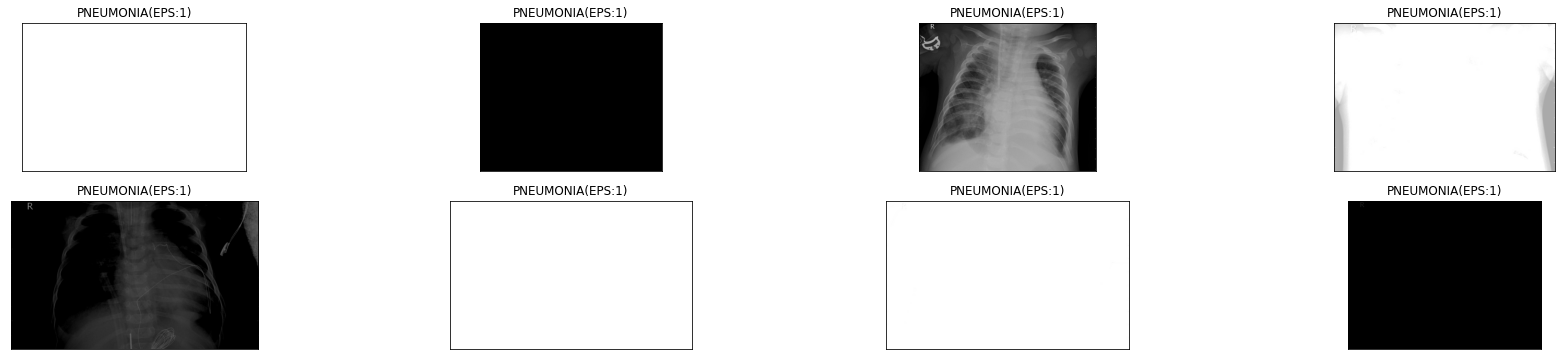

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:1)')

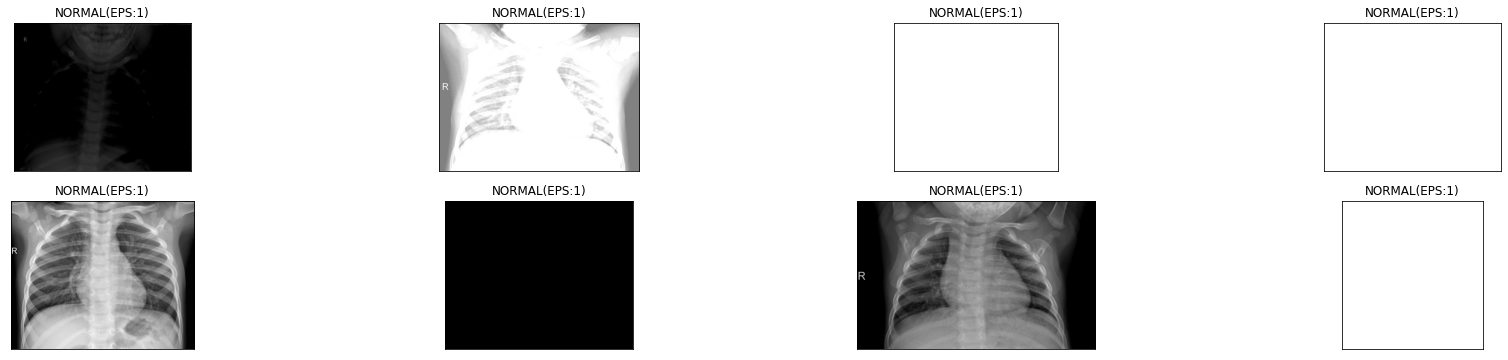

In [22]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:1)')